# Import Libraries

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
import torch
%matplotlib inline  

2024-06-23 20:14:39.038256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 20:14:39.038355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 20:14:39.157537: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Import the model
We can choose *Florence-2-large* or *Florence-2-large-ft* (fine-tuned).

In [2]:
%pip install einops flash_attn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.1 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.5.9.post1-cp310-cp310-linux_x86_64.whl size=120576656 sha256=0f3dddbf9bc350ea6b0306ec5ca5fee71b57fe1f06e6b72672690793d9dad2ce
  Stored in directory: /root/.cache/pip/wheels/cc/ad/f6/7ccf0238790d6346e9fe622923a76ec218e890d356b9a2754a
Successfully built flash_attn
Note: you may need to restart the kernel to use updated packages.


In [3]:
model_id = 'microsoft/Florence-2-large-ft'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
model = model.to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
device

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

device(type='cuda')

# Define inference function

In [4]:
def run_inference(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

# Get image link

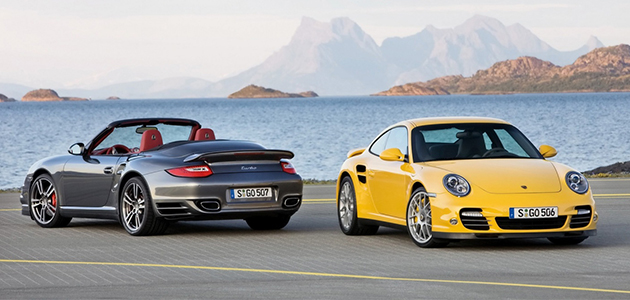

In [5]:
image_url = "http://lerablog.org/wp-content/uploads/2013/06/two-cars.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image


# Run pre-defined tasks without additional inputs
## Caption





In [6]:
task_prompt = '<CAPTION>'
run_inference(task_prompt)

{'<CAPTION>': 'Two sports cars parked next to each other on a road.'}

In [7]:
task_prompt = '<DETAILED_CAPTION>'
run_inference(task_prompt)

{'<DETAILED_CAPTION>': 'In this image we can see two cars on the road. In the background, we can also see water, hills and the sky.'}

In [8]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_inference(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'There are two cars parked on the street. There is water behind the cars. There are mountains behind the water. The cars are yellow and black. '}

# Object Detection

In [9]:
task_prompt = '<OD>'
results = run_inference(task_prompt)
print(results)

{'<OD>': {'bboxes': [[336.1050109863281, 115.95000457763672, 599.4450073242188, 248.5500030517578], [18.584999084472656, 117.45000457763672, 304.6050109863281, 236.25001525878906], [113.08499908447266, 177.15000915527344, 172.30499267578125, 235.95001220703125], [404.1449890136719, 187.95001220703125, 454.54498291015625, 248.25001525878906], [336.1050109863281, 176.25, 380.2049865722656, 235.95001220703125], [26.774999618530273, 173.85000610351562, 73.3949966430664, 228.15000915527344], [244.125, 216.15000915527344, 291.375, 231.15000915527344], [546.5250244140625, 236.5500030517578, 588.7349853515625, 245.85000610351562], [481.635009765625, 148.35000610351562, 509.3550109863281, 157.65000915527344]], 'labels': ['car', 'car', 'wheel', 'wheel', 'wheel', 'wheel', 'wheel', 'wheel', 'wheel']}}


In [10]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

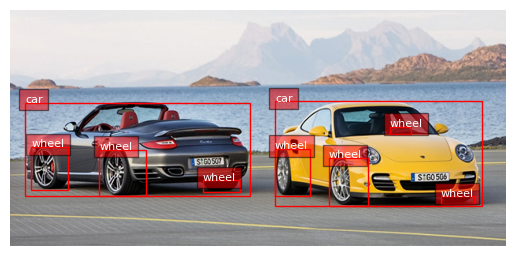

In [11]:
plot_bbox(image, results['<OD>'])

# Dense Region Caption

In [12]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_inference(task_prompt)
dense_region_res = results
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[334.8450012207031, 115.95000457763672, 599.4450073242188, 248.5500030517578], [18.584999084472656, 117.45000457763672, 304.6050109863281, 236.25001525878906], [113.71499633789062, 177.15000915527344, 172.30499267578125, 235.95001220703125], [404.1449890136719, 187.95001220703125, 453.9150085449219, 248.25001525878906], [26.774999618530273, 173.85000610351562, 73.3949966430664, 228.15000915527344], [336.1050109863281, 176.25, 380.2049865722656, 235.95001220703125], [244.125, 216.45001220703125, 290.7449951171875, 230.85000610351562], [546.5250244140625, 236.5500030517578, 588.7349853515625, 245.85000610351562], [481.635009765625, 148.35000610351562, 509.3550109863281, 157.65000915527344]], 'labels': ['yellow sports car', 'sports car', 'wheel', 'wheel', 'wheel', 'wheel', 'wheel', 'wheel', 'wheel']}}


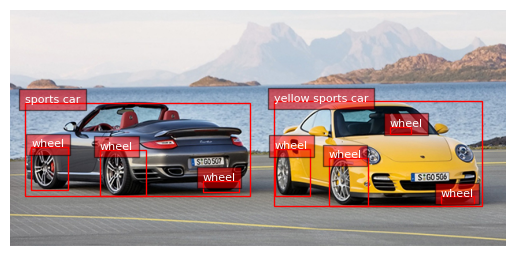

In [13]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

# Phrase Grounding

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[335.4750061035156, 115.6500015258789, 601.9649658203125, 250.35000610351562], [0.3149999976158142, 12.15000057220459, 629.0549926757812, 103.6500015258789]], 'labels': ['Yellow car', 'islands']}}


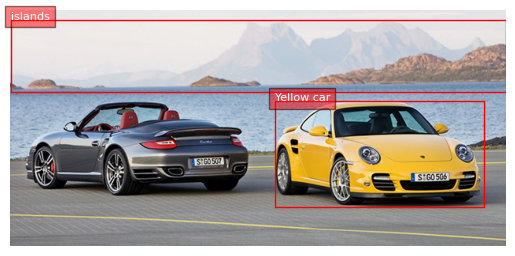

In [14]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_inference(task_prompt, text_input="Yellow car with islands in background")
print(results)
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

# Segmentation

In [15]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_inference(task_prompt, text_input="yellow car and island")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[348.07501220703125, 149.85000610351562, 364.4549865722656, 147.75, 387.135009765625, 126.75000762939453, 414.8550109863281, 118.35000610351562, 473.44500732421875, 116.25000762939453, 508.7250061035156, 120.45000457763672, 538.3350219726562, 147.15000915527344, 545.2650146484375, 145.0500030517578, 557.2349853515625, 149.25, 557.864990234375, 156.15000915527344, 547.7849731445312, 159.75, 572.9849853515625, 169.65000915527344, 588.7349853515625, 178.0500030517578, 596.9249877929688, 202.65000915527344, 599.4450073242188, 223.65000915527344, 596.9249877929688, 236.25001525878906, 588.7349853515625, 237.75001525878906, 579.2849731445312, 246.15000915527344, 553.4550170898438, 246.15000915527344, 547.1549682617188, 239.85000610351562, 450.135009765625, 239.85000610351562, 438.79498291015625, 248.25001525878906, 419.2649841308594, 248.25001525878906, 407.92498779296875, 237.75001525878906, 406.6650085449219, 229.35000610351562, 378.94

In [16]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np

colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']

def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

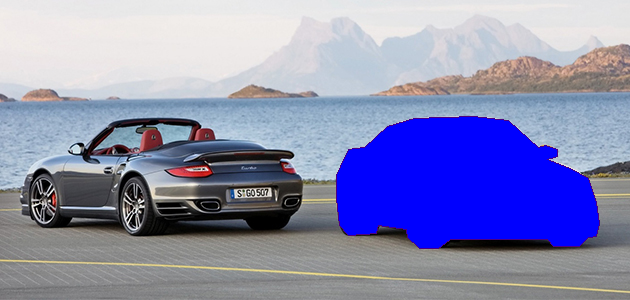

In [17]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)  

## Regions Segmentation

In [18]:
def bbox_to_loc(bbox):
#     [334.8450012207031, 115.35000610351562, 601.3350219726562, 250.65000915527344]
    return f"<loc_{int(bbox[0]*999/width)}><loc_{int(bbox[1]*999/height)}><loc_{int(bbox[2]*999/width)}><loc_{int(bbox[3]*999/height)}>"

with torch.no_grad():
    torch.cuda.empty_cache()

<loc_530><loc_386><loc_950><loc_827>


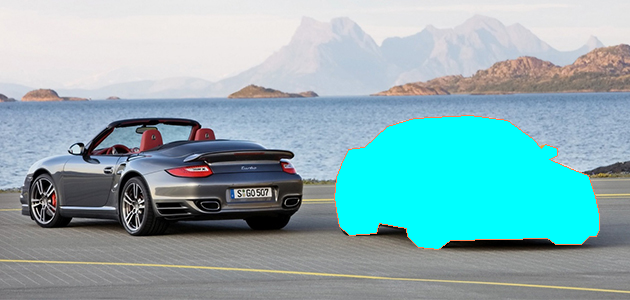

<loc_29><loc_391><loc_483><loc_786>


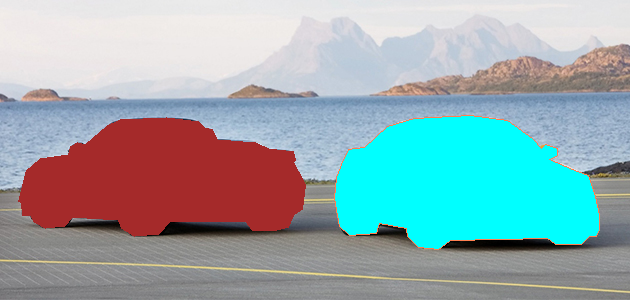

<loc_180><loc_589><loc_273><loc_785>


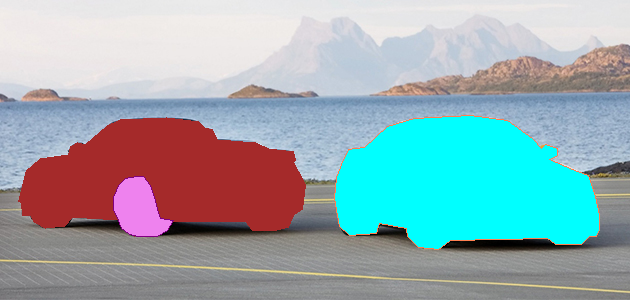

<loc_640><loc_625><loc_719><loc_826>


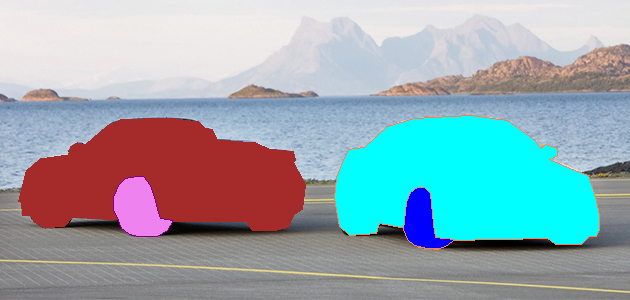

<loc_42><loc_578><loc_116><loc_759>


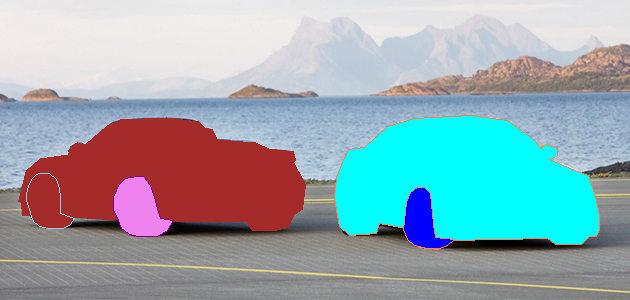

<loc_532><loc_586><loc_602><loc_785>


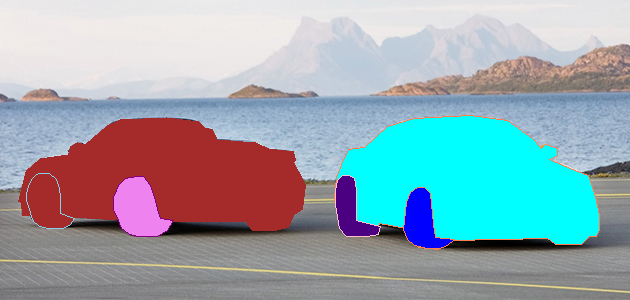

<loc_387><loc_720><loc_461><loc_768>


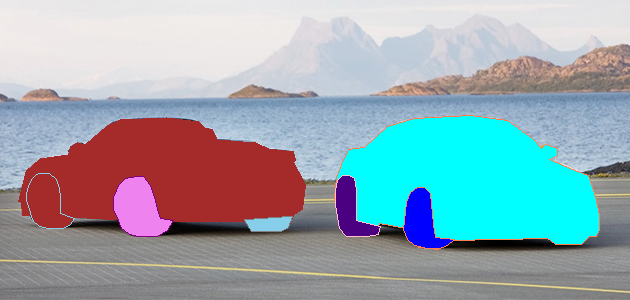

<loc_866><loc_787><loc_933><loc_818>


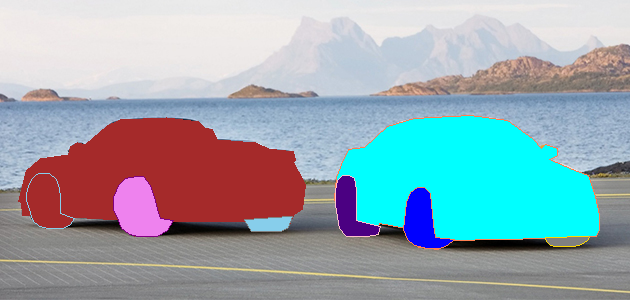

<loc_763><loc_494><loc_807><loc_524>


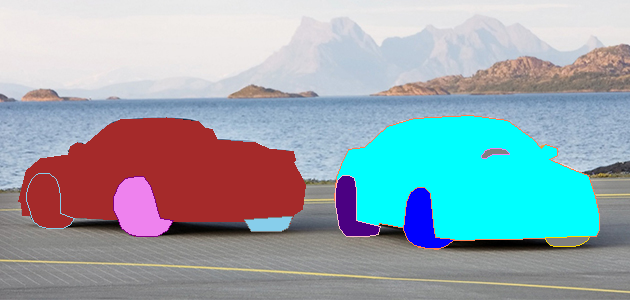

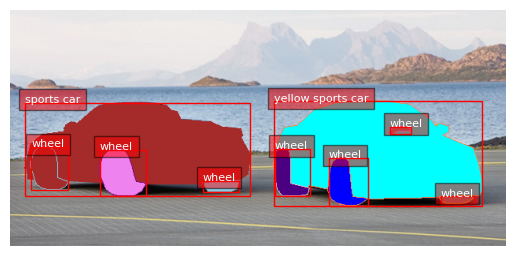

In [19]:
output_image = copy.deepcopy(image)
height, width = image.height, image.width 
task_prompt = '<REGION_TO_SEGMENTATION>'

for bbox in dense_region_res['<DENSE_REGION_CAPTION>']['bboxes'][:]:
    print(bbox_to_loc(bbox))
    results = run_inference(task_prompt, text_input=bbox_to_loc(bbox)) 
    draw_polygons(output_image, results[task_prompt], fill_mask=True)  
    
plot_bbox(output_image, dense_region_res['<DENSE_REGION_CAPTION>'])

# OCR

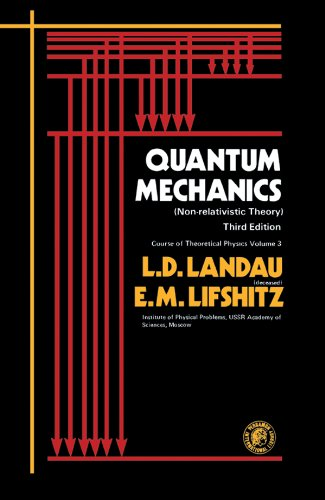

In [20]:
url = "https://m.media-amazon.com/images/I/510sf0pRTlL.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
image

In [21]:
task_prompt = '<OCR_WITH_REGION>'
results = run_inference(task_prompt)
print(results)

{'<OCR_WITH_REGION>': {'quad_boxes': [[143.8125, 146.25, 280.9624938964844, 146.25, 280.9624938964844, 172.25, 143.8125, 172.25], [134.0625, 176.25, 281.9375, 176.25, 281.9375, 202.25, 134.0625, 202.25], [172.73748779296875, 206.25, 284.2124938964844, 206.25, 284.2124938964844, 216.25, 172.73748779296875, 216.25], [150.3125, 238.25, 281.9375, 238.25, 281.9375, 247.25, 150.3125, 247.25], [139.58749389648438, 254.25, 284.2124938964844, 254.25, 284.2124938964844, 277.75, 139.58749389648438, 277.75], [133.08749389648438, 283.75, 285.1875, 283.75, 285.1875, 307.75, 133.08749389648438, 307.75], [140.5625, 312.75, 281.9375, 312.75, 281.9375, 320.75, 140.5625, 320.75]], 'labels': ['</s>QUANTUM', 'MECHANICS', '(Non-relativistic Theory)', 'Course of Theoretical Phyias Volume 3', 'L.D. LANDAU', 'E.M. LIFSHITZ', 'Initiute of Physical Problems, USSR Academy of']}}


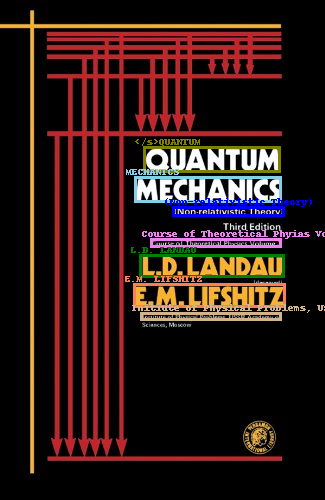

In [22]:
def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]-8, new_box[1]-10),
                    "{}".format(label),
                    align="right",
                    fill=color)
    display(image)

output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])  